In [149]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline


In [150]:
words = open('names.txt', 'r').read().splitlines()
words[:2]

['emma', 'olivia']

In [151]:
chars = sorted(list(set(''.join(words))))
chars.insert(0, '.')

stoi = {c:i for i,c in enumerate(chars)}
itos = { i:c for i,c in enumerate(chars)}
vocab_size = len(itos)

In [152]:
import random

block_size = 3

def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w:
            ix = stoi[ch]
            X.append(context)
    
            Y.append(ix)
            # print(''.join(itos[i] for i in context), ' --->', itos[ix])
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y. shape)
    return X, Y

random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))


Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([156999, 3]) torch.Size([156999])
torch.Size([19452, 3]) torch.Size([19452])
torch.Size([19662, 3]) torch.Size([19662])


In [156]:
n_embed = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embed), generator=g) # 2 col embedding vector for each character
W1 = torch.randn((block_size * n_embed, n_hidden), generator=g) * (5/3)/((block_size * n_embed)**0.5) # Normalize/reduce values of W1 to avoid saturation of tanh activation
# but in there embedding form (so 3 embeddings flattened). 100 out is design choice
# b1 = torch.randn(n_hidden, generator=g) * 0.01 ## setting biases to close to 0, as at step 0, we want to avoid having probabilities > 1/vocab_size
 ## because why should an untrained network know to output one character over another
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01 ## we reduce weights by factor of 10^-2 for similar reasons here
## Because if resultant logits are large, it implies false confidence in specific characters. Unless the Y indexes pick out those high values
## the resultant loss will be large
b2 = torch.randn(vocab_size, generator=g) * 0 

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

bnmean_running = torch.ones((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(f"Total number of params: {sum(p.nelement() for p in parameters)}")
for p in parameters:
    p.requires_grad = True

Total number of params: 12097


In [157]:
# # if we are lucky with inital random assignment
# logits1 = torch.tensor([0.0, 2.0, -0.3, -10.1])
# probs1 = torch.softmax(logits1, dim=0)
# loss1 = -probs1[1].log() #1 is the training Y index, and is fortunately large, so loss will be low


# #bad logits due to large inital weights example -> leads to large loss we have to mediate in first N steps (uncessary work!)
# logits2 = torch.tensor([0.0, 7.0, -3.0, 1.0])
# exp2 = logits2.exp()
# probs2 =  torch.softmax(logits2, dim=0)
# loss2 = probs2[2].log() #here we assume the correct output char is at index 2
# logits1, probs1, loss1, logits2, exp2, probs2, loss2

In [158]:


# lre = torch.linspace(-3, 0, epochs)
# lrs = 10**lre
# lri = []

batch_size = 32
max_steps = 200000

lossi = []
# iz = []


for i in range(max_steps):
    ## construct minibatch indexes
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    ## forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 #+ b1 #when using batch normalization, bnmean effectively strips the layer bias out and bnbias takes over this role, so we can remove it
        ## BatchNorm Layer
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    
    hpreact =  bngain * ((hpreact - bnmeani)/ bnstdi) + bnbias

        #accumulate estimate for bnmean and bnstd for entire training set
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
        
    h = torch.tanh( hpreact) # (word-grams, 100)
    logits = h @ W2 + b2 # (100, 27)
    loss = F.cross_entropy(logits, Yb)
    # print(f"Loss at epoch {k}: {(loss.item()):.4f}, lr was {lrs[k]:.4f}") 
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    # lr = 0.0001
    #update
    for p in parameters:
        p.data += -lr * p.grad

    # #track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    # lri.append(lrs[k])
    # break  
# plt.plot(lri

      0/ 200000: 3.3023
  10000/ 200000: 2.3210
  20000/ 200000: 2.0799
  30000/ 200000: 2.4238
  40000/ 200000: 2.2365
  50000/ 200000: 2.1992
  60000/ 200000: 2.3269
  70000/ 200000: 2.4307
  80000/ 200000: 2.3572
  90000/ 200000: 1.9672
 100000/ 200000: 2.2255
 110000/ 200000: 2.0786
 120000/ 200000: 2.3213
 130000/ 200000: 2.4597
 140000/ 200000: 2.2014
 150000/ 200000: 2.2182
 160000/ 200000: 2.5412
 170000/ 200000: 1.8623
 180000/ 200000: 1.8665
 190000/ 200000: 1.6702


In [135]:
# import math
# import numpy as np
# xx = np.arange(-12, 12, 0.1)
# yy = np.tanh(xx)

# plt.plot(xx, yy)

In [110]:
%%skip
## Without normalization, majority of values in h are -1 and 1 (tanh 'squashes' between -1 and 1)
## recalling that gradient of tanh => (1 - x**2) * grad, if any value of h is 1 or -1, the resultant gradient will be 0 (I.e. the gradient will be dead from then on!)
## this makes sense, as, for large values above tanh squashes values to 1 or -1 and stops. So gradient in that region IS 0.

# ##for this reason, we need to normalize
plt.hist(h.view(-1).tolist(), 50);

UsageError: Cell magic `%%skip` not found.


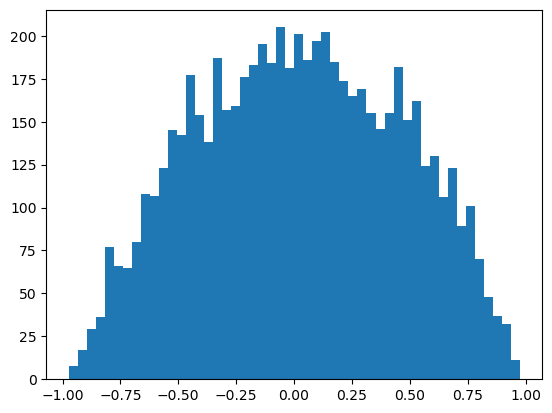

In [111]:
# WITH normalization of weights:
# ##for this reason, we need to normalize
plt.hist(h.view(-1).tolist(), 50);

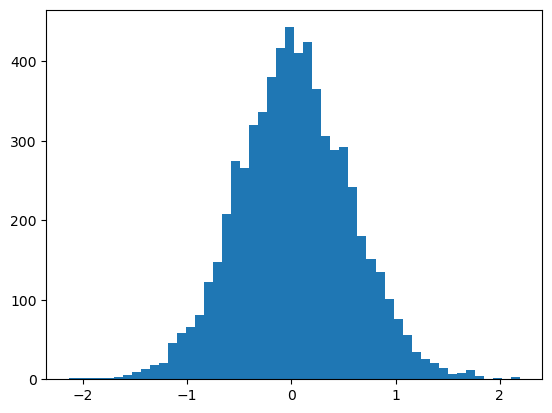

In [112]:
# (with W1 randomly initialized, no normalization) if we inspect the activations flowing into tanh, we can see that many values sit above the tanh thresholds, and will result in many outputs of 1 or -1!
# otherwise, we see a histogram that sits nicely without bounds of -1 and 1
plt.hist(hpreact.view(-1).tolist(), 50);

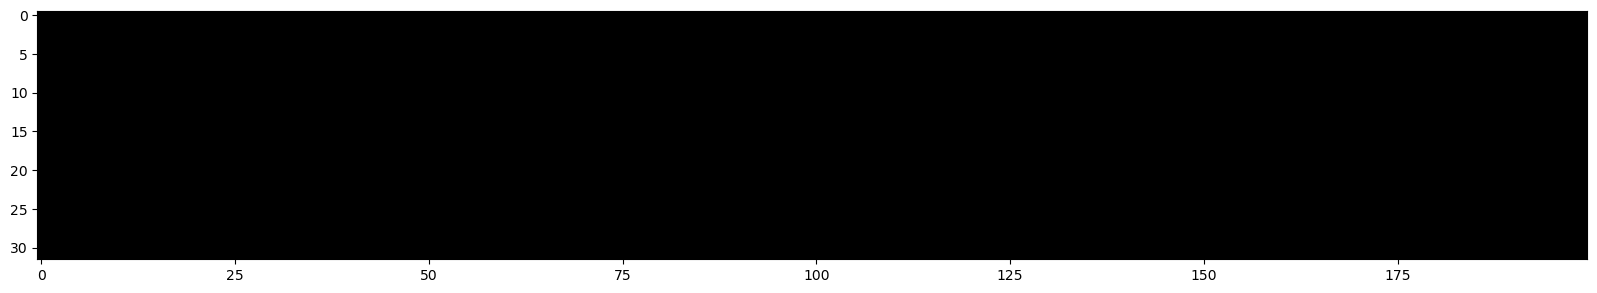

In [113]:
# here we can visualize the number of activations that will set the resultant gradient to 0 in a backward pass (white squares)
# note that each row shows the 200 weights for each sample. If a column is all white, you have a dead neuron!
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap="gray", interpolation="nearest")

In [127]:
# # calibrate the batch norm at end of training

# with torch.no_grad():
#     # pass training set through
#     emb = C[Xtr]
#     embcat = emb.view(emb.shape[0], -1)
#     hpreact = embcat @ W1 + b1
#     #measure mean and std dev over entire training set
#     bnmean = hpreact.mean(0, keepdim=True)
#     bnstd = hpreact.std(0, keepdim=True)

In [133]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (test rows, block_size ) indexing a (word_size, n_embed) => (n_rows, block_size, n_embed) )
    embcat = emb.view(emb.shape[0], -1) # (n_rows, embed_size * block_size * n_embed)a
    hpreact = embcat @ W1 + b1
    hpreact =  bngain * ((hpreact - bnmean_running)/ bnstd_running) + bnbias ##using batch norm over entire training set vs. those calc'd during training
    h = torch.tanh( hpreact) # (word-grams, 100)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')






train 2.1040475368499756
val 2.1498501300811768


In [141]:
for _ in range(20):
    out = []
    context = [0] * block_size #(3)
    while True:
        emb = C[torch.tensor([context])] # (1, 3) indexing a (27, 2) => (1, 3, 2)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1) # (1, 6) @ (6, 100)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

.
.
.
.
z.
.
.
.
.
.
b.
.
.
.
.
.
.
z.
.
.


In [159]:
##Pytorchify

In [228]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn(fan_in, fan_out, generator=g) /fan_in**0.5 #kaiming initilization
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
        
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        #running val buffers
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat =  (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []


n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embed), generator=g)

layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

#set gains/ adjust final layer confidence etc.
with torch.no_grad():
    layers[-1].gamma *= 0.1
    # all other layers apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            l.weight *=  5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
for p in parameters:
    p.requires_grad = True

print(sum(p.nelement() for p in parameters))

47024


In [229]:
max_steps = 200000
batch_size = 32
lossi, ud = [], []

for i in range(max_steps):
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    x = emb.view(Xb.shape[0], -1)
    for layer in layers:
        x = layer(x)

    loss = F.cross_entropy(x, Yb)

    #backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None

    loss.backward()

    #update
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    with torch.no_grad():
        #capturing the ration of update to data, ideal is ~ 1e-03
         ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    if i >= 1000:
        break
    

      0/ 200000: 3.3138


layer 2 (      Tanh): mean +0.00, std 0.63, saturated: 3.19%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.72%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.28%
layer 11 (      Tanh): mean -0.00, std 0.65, saturated: 1.72%
layer 14 (      Tanh): mean +0.00, std 0.65, saturated: 2.16%


Text(0.5, 1.0, 'activation distribution')

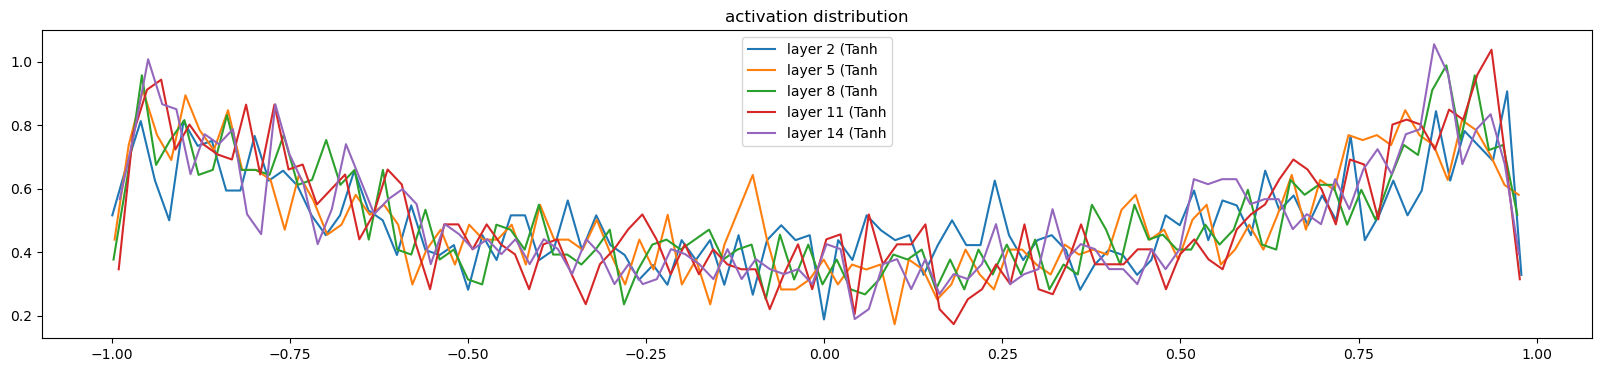

In [230]:
# visualize histograms of activations
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh): #alter layer type here to see difference layers
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 2.278965e-03
layer 5 (      Tanh): mean +0.000000, std 2.021625e-03
layer 8 (      Tanh): mean +0.000000, std 1.882913e-03
layer 11 (      Tanh): mean +0.000000, std 1.660570e-03
layer 14 (      Tanh): mean +0.000000, std 1.722716e-03


Text(0.5, 1.0, 'gradient distribution')

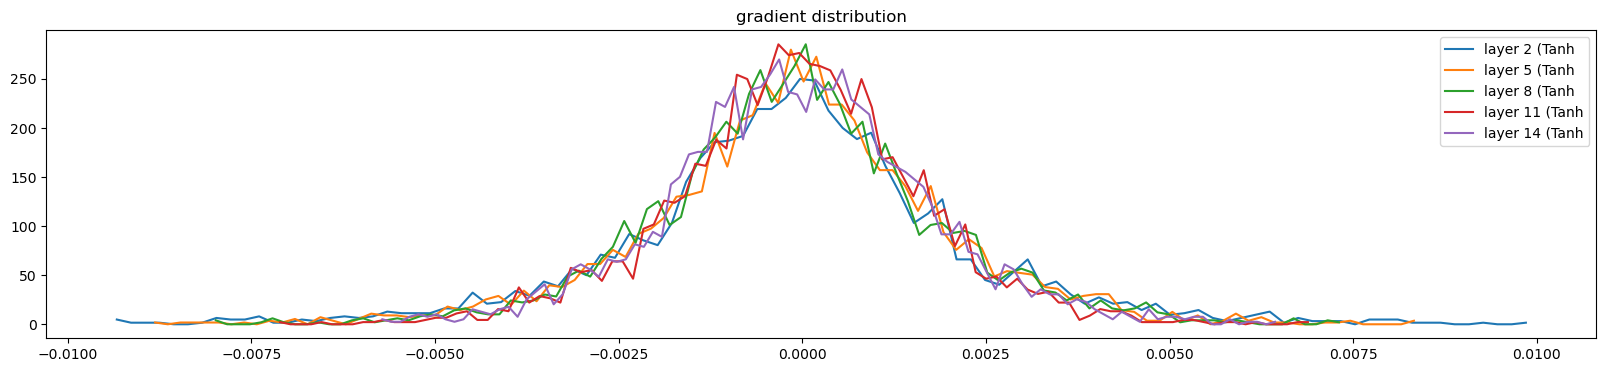

In [231]:
# visualize histograms of activation gradients
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh): #alter layer type here to see difference layers
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 8.107661e-03 | grad:data ratio 8.099734e-03
weight  (30, 100) | mean +0.000026 | std 8.516765e-03 | grad:data ratio 4.499174e-02
weight (100, 100) | mean +0.000016 | std 6.108467e-03 | grad:data ratio 5.971038e-02
weight (100, 100) | mean -0.000052 | std 5.637681e-03 | grad:data ratio 5.493106e-02
weight (100, 100) | mean -0.000054 | std 5.136862e-03 | grad:data ratio 5.042981e-02
weight (100, 100) | mean +0.000004 | std 4.837282e-03 | grad:data ratio 4.755973e-02
weight  (100, 27) | mean -0.000020 | std 1.048965e-02 | grad:data ratio 1.008768e-01


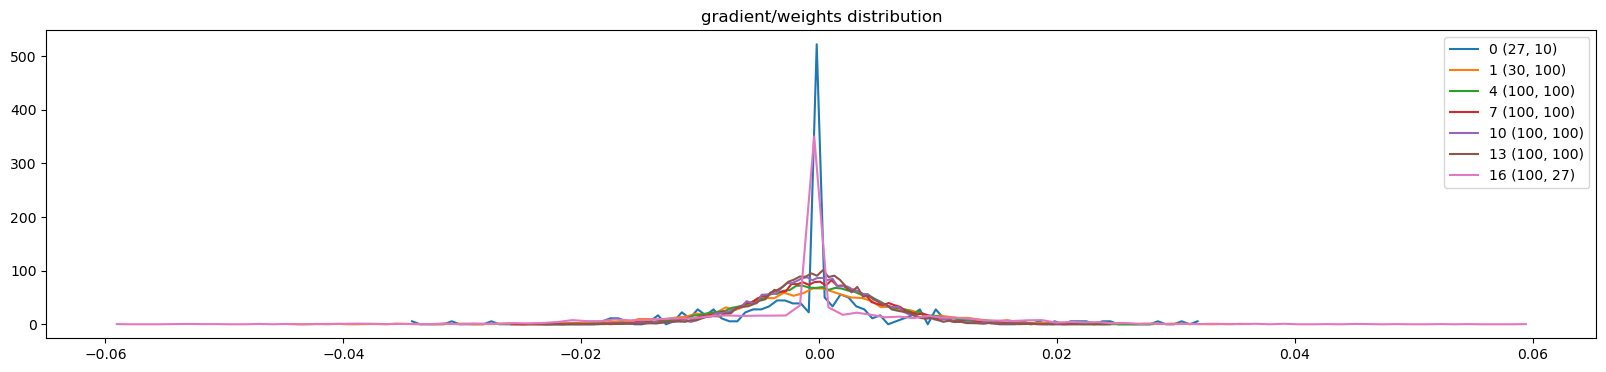

In [232]:
# visualize histograms for gradient/weight ratio
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('gradient/weights distribution');

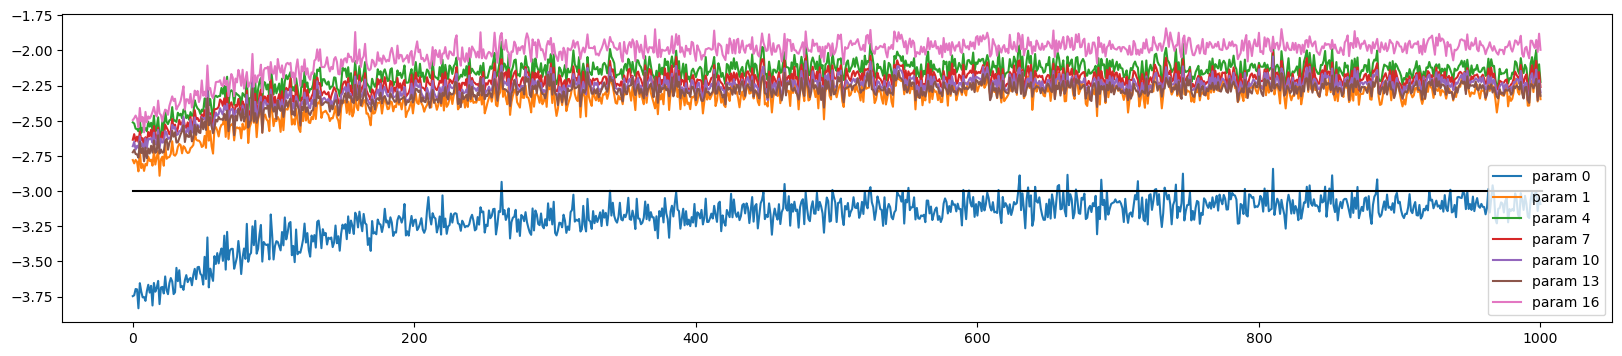

In [233]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2: #get only weight layers (batch, gamma, beta are all ndim = 1)
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [192]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

C:\Users\James\AppData\Local\Temp\ipykernel_6532\565766621.py:30: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1808.)
  xvar = x.var(0, keepdim=True)


RuntimeError: probability tensor contains either `inf`, `nan` or element < 0